# Background Information

When an analyst estimates the price of a house, they need to consider many predictors, including its location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict house prices. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# Import Libraries and Data

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

sns.set_theme()

In [36]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv("ames_houses_data.csv", index_col="Order")
X = houses_data.drop(columns=["price"])
y = houses_data.loc[:, "price"]
print("X size: ", X.shape)

X size:  (2930, 80)


For simplicity, I only used countinuous, discrete, and ordinal predictors to train my models. Hence, I removed all of the nominal predictors from the dataset.

In [37]:
X = X.select_dtypes(include="number")

# Manually remove nominal columns encoded with integers
X.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True)

print("X size after removing unwanted predictors: ", X.shape)

X size after removing unwanted predictors:  (2930, 34)


I then split the dataset into a training set (80%) and a test set (20%). 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)

X_train size:  (2344, 34)
X_test size:  (586, 34)


# Exploratory Data Analysis

## Distributions of the variables

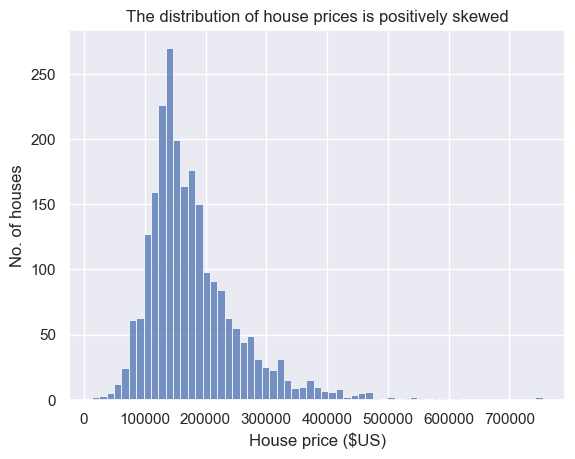

In [39]:
# Distribution of house prices (the target)
sns.histplot(y_train)
plt.title("The distribution of house prices is positively skewed")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.show()

The distribution of house prices is positively skewed due to a few very expensive houses.

In [40]:
# # Uncomment if you want to run (takes a while).
# X_train.hist(figsize=(15, 17))
# plt.show()

![](predictor_histograms.png)

Many of the predictors (Pool.Area, Screen.Porch) are 0 for most of the houses. For example:
- **Pool.Area**: Pool area 
- **Screen.Porch**: Screen porch area

This is because most houses do not have these amenities.

## Correlations between variables

Due to the large number of predictors, a correlation heatmap would be hard to read. Hence, I did not include one.

In [41]:
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

### Correlations with the target (house price)

In [42]:
most_positive = correlation_matrix.loc["price"].sort_values(ascending=False)[0:5]
print(
    f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n",
    most_positive,
    "\n",
    sep="",
)

most_negative = correlation_matrix.loc["price"].sort_values(ascending=True)[0:1]
print(
    f"The predictor that was most negatively correlated with house price was:\n",
    most_negative,
    sep="",
)

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.795298
area             0.698315
Garage.Cars      0.644304
Garage.Area      0.633106
Total.Bsmt.SF    0.612256
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.130722
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage. (Notice that is is highly correlated with GarageCars). 

None of the predictors were significantly negatively correlated with the house price.

### Correlations between predictors

In [43]:
most_positive = correlation_matrix.stack().sort_values(ascending=False)[0:5]
print(
    f"The {len(most_positive)} predictor pairs that were most positively correlated were:\n",
    most_positive,
    "\n",
    sep="",
)

most_negative = correlation_matrix.stack().sort_values(ascending=True)[0:1]
print(
    f"The predictor pair that was most negatively correlated was:\n",
    most_negative,
    sep="",
)

The 5 predictor pairs that were most positively correlated were:
Garage.Area    Garage.Cars      0.883871
Garage.Yr.Blt  Year.Built       0.824690
X1st.Flr.SF    Total.Bsmt.SF    0.813946
TotRms.AbvGrd  area             0.806434
price          Overall.Qual     0.795298
dtype: float64

The predictor pair that was most negatively correlated was:
Bsmt.Unf.SF  BsmtFin.SF.1   -0.47883
dtype: float64


Collinear predictors (multicollinearity) increase the uncertainty in the estimated regression coefficients, which makes models less interpretable. However, they do not affect prediction accuracy, so I will not remove them.

# Training Set Procesesing

Each step in the data processing can be represented by a scikit-learn transformer object. These transfromers can be assembled into a Pipeline object, which can be used to apply all of the data processing steps to new data in one method call.

## Data Standardization

I will use scikit-learn's StandardScaler transformer to standardize each predictor variable to a mean of 0 and a standard deviation of 1. This will improve the training speed and performance of the regression models.

## Handling missing data

Regression models cannot be trained on data with missing values. The simplest solution is to delete data points with missing values. But data points with a few missing predictor values still have a lot of information in their other predictor values. So a better option is to replace missing data with a best guess based on other data in the dataset (data imputation). 

I will use the KNNImputer transformer to impute missing data. For each data point with missing predictor values, k-Nearest Neighbors:
1. Identifies the k data points that are closest to it in the predictor space.
2. Takes the averages of their predictor values and uses them to impute the missing values.  

## Data Processing Pipeline

In [44]:
data_processing = make_pipeline(StandardScaler(), KNNImputer())

## Removing High Leverage Points

High leverage points (HLPs) are far away from other data points in the predictor space. They can worsen the fit on the rest of the data points. I will use the IsolationForest estimator to identify HLPs, then I will manually remove them. I will use principal component analysis to visually estimate the threshold for HLP classification. Technically, this should be a step in the data processing pipeline, but scikit-learn does not support HLP removal.

In [45]:
def remove_HLP(
    pred_HLP: np.ndarray, X: pd.DataFrame, y: pd.Series
) -> (pd.DataFrame, pd.Series):
    num_HLP = np.count_nonzero((pred_HLP == -1))
    perc_HLP = num_HLP / len(y_train) * 100
    print(f"{perc_HLP: .2f}% of the data points were identified as HLPs and removed.")

    not_HLP = pred_HLP == 1
    return (X[not_HLP], y[not_HLP])

In [46]:
X_train_old = X_train  # keep a copy to plot the removed HLPs
hlp_pipe = make_pipeline(
    data_processing, IsolationForest(random_state=42, contamination=0.004)
)
hlp_pipe.fit(X_train)
X_train, y_train = remove_HLP(hlp_pipe.predict(X_train), X_train, y_train)

 0.43% of the data points were identified as HLPs and removed.


I will use principal component analysis (PCA) to estimate an appropriate HLP classification threshold. PCA summarizes the variance in the predictor space in a lower-dimensional principal component space. Hence, high leverage points are also isolated in the principal component space, where they can be visually identified.

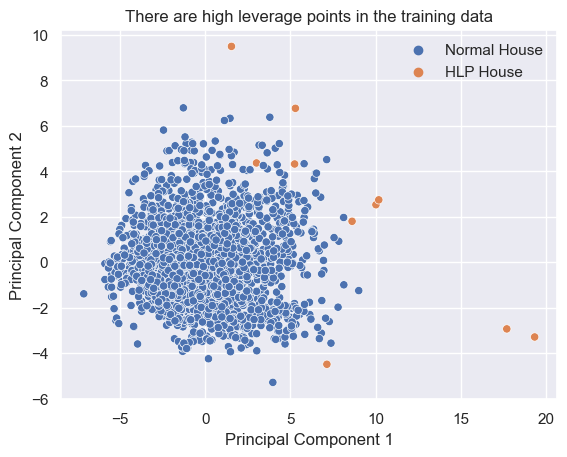

In [47]:
pca_pipe = make_pipeline(data_processing, PCA(n_components=2))
pc_scores = pd.DataFrame(pca_pipe.fit_transform(X_train_old), columns=["PC1", "PC2"])
is_HLP = pd.Series((hlp_pipe.predict(X_train_old) == -1), name="is_HLP")
pc_scores = pd.concat([pc_scores, is_HLP], axis=1)

ax = sns.scatterplot(data=pc_scores, x="PC1", y="PC2", hue="is_HLP")
plt.title("There are high leverage points in the training data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Normal House", "HLP House"], frameon=False)
plt.show()

# Linear Regresssion

One of the simplest models we can use to predict the house prices is multiple linear regression. I will now train a multiple linear regression model on the entire training set then fit it on the training set to obtain a residual plot.

In [48]:
linear_pipe = make_pipeline(data_processing, LinearRegression())
linear_pipe.fit(X_train, y_train)
pred_y_train = pd.Series(linear_pipe.predict(X_train), index=X_train.index)
train_residuals = y_train - pred_y_train

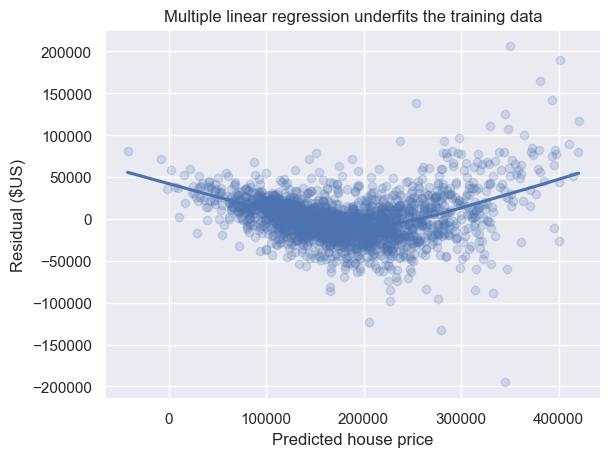

In [49]:
sns.regplot(
    x=pred_y_train, y=train_residuals, scatter_kws={"alpha": 0.2}, lowess=True
)  # locally weighted linear regression

plt.title("Multiple linear regression underfits the training data")
plt.xlabel("Predicted house price")
plt.ylabel("Residual ($US)")
plt.show()

The residual plot is curved, which suggests that linear regression underfits the training data.

Since the test set is reserved for the evaluation of our final model, I will use cross-validation to evaluate the multiple linear regression model. Since I will be evaluating many regression models, I will create a function to calculate the regression scores for each.

In [50]:
def regression_scores(reg_pipe: Pipeline) -> dict:
    reg_scores = cross_validate(
        reg_pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        return_estimator=True,
        n_jobs=-1,
    )
    train_scores = reg_scores["train_score"]
    print(
        f"Mean NRMSE for training sets: {train_scores.mean():.2f} ({train_scores.std():.2f} SD)"
    )
    test_scores = reg_scores["test_score"]
    print(
        f"Mean NRMSE for validation sets: {test_scores.mean():.2f} ({test_scores.std():.2f} SD)"
    )
    return reg_scores

In [51]:
reg_scores = regression_scores(linear_pipe)

Mean NRMSE for training sets: -26478.23 (371.98 SD)
Mean NRMSE for validation sets: -27012.96 (1416.68 SD)


The higher the negative root mean square error (NRMSE) scores, the better the model is. The scores for the training sets and validation sets are very similar, suggesting the model may be underfitting.

# Polynomial Regression

To increase model complexity, I will add second-order predictors that are powers and products of the original predictors.

In [52]:
quad_pipe = make_pipeline(
    data_processing, PolynomialFeatures(degree=2), LinearRegression()
)

In [53]:
quad_pipe.fit(X_train, y_train)
quadratic = quad_pipe["linearregression"]
num_coef = len(quadratic.coef_[quadratic.coef_ != 0])
print(f"Number of coefficients: {num_coef}")

Number of coefficients: 630


This are a lot of predictors compared to the number of data points (around 2000), so we expect the model to overfit.

In [54]:
reg_scores = regression_scores(quad_pipe)

Mean NRMSE for training sets: -15950.79 (221.13 SD)
Mean NRMSE for validation sets: -5617733476428074.00 (7109560467926945.00 SD)


Since the score is much higher for the training sets than the validation sets, the model is overfitting.

# Lasso Regression

Lasso regression restricts the magnitudes of the regression coefficients to prevent overfitting. It can also set coefficients to 0, effectively removing predictors from the model. The amount of restriction is controlled by a hyperparameter ($\alpha$). 

Hyperparameter values are empirically determined by trying a range of different values and seeing which one yields the lowest prediction errors. This process is called hyperparameter tuning and can be accomplished using GridSearchCV(). 

In [55]:
# I started with a very wide search range between 0.1 and 100,000, then narrowed it down.
param_grid = {"alpha": np.linspace(600, 1200, num=5)}
search_pipe = make_pipeline(
    data_processing,
    PolynomialFeatures(degree=2),
    GridSearchCV(
        Lasso(), param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1
    ),
)

In [56]:
reg_scores = regression_scores(search_pipe)

Mean NRMSE for training sets: -20115.39 (539.18 SD)
Mean NRMSE for validation sets: -22120.16 (1386.25 SD)


The mean score on the validation set is the highest out of all the models tested so far, indicating that this is the best model so far.

The cell below returns the obtained $\alpha$ value for each cross-validation iteration to help me tune the range of $\alpha$ values to test in GridSearchCV().

In [57]:
def print_cv_hyperparams(reg_scores: dict):
    # retrieve a list of the tuned pipelines
    search_pipes = reg_scores["estimator"]
    print("The best hyperparameter values for each CV iteration were:")
    for i, search_pipe in enumerate(search_pipes):
        search = search_pipe["gridsearchcv"]
        print(search.best_params_)


print_cv_hyperparams(reg_scores)

The best hyperparameter values for each CV iteration were:
{'alpha': 1050.0}
{'alpha': 1050.0}
{'alpha': 750.0}
{'alpha': 1050.0}
{'alpha': 750.0}


Due to the small training set size, there is a lot of variance in the tuned models' hyperparameter values.

Since the quadratic lasso model performs well, I will now train it on the entire training set then evaluate it using the test set.

In [58]:
param_grid = {"alpha": np.linspace(400, 800, num=5)}
search_pipe = make_pipeline(
    data_processing,
    PolynomialFeatures(degree=2),
    GridSearchCV(
        Lasso(), param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
    ),
)

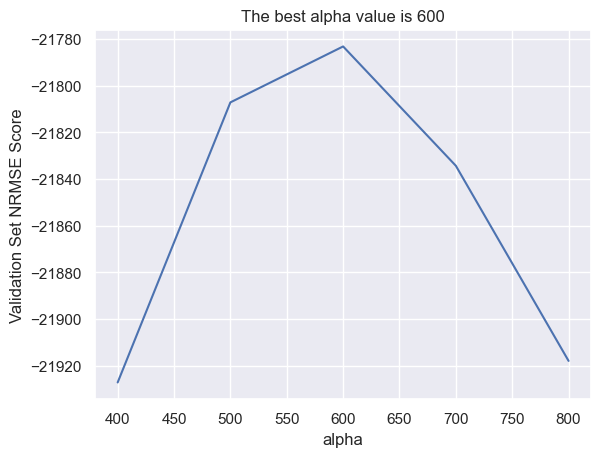

In [59]:
search_pipe.fit(X_train, y_train)
search = search_pipe["gridsearchcv"]
best_alpha = search.best_params_["alpha"]
mean_test_scores = search.cv_results_["mean_test_score"]
alpha_vs_NRMSE = pd.DataFrame(mean_test_scores, param_grid["alpha"])

sns.lineplot(alpha_vs_NRMSE, legend=False)

plt.title(f"The best alpha value is {int(best_alpha)}")
plt.xlabel("alpha")
plt.ylabel("Validation Set NRMSE Score")
plt.show()

In [60]:
lasso_pipe = make_pipeline(
    data_processing, PolynomialFeatures(degree=2), Lasso(alpha=best_alpha)
)

In [61]:
lasso_pipe.fit(X_train, y_train)
lasso = lasso_pipe["lasso"]
num_coef = len(lasso.coef_)
num_zero_coef = len(lasso.coef_[lasso.coef_ == 0])
print(f"Number of non-zero coefficients: {(num_coef - num_zero_coef)}")
print(f"Percentage of coefficients removed: {int(num_zero_coef / num_coef * 100)}%")

Number of non-zero coefficients: 120
Percentage of coefficients removed: 80%


Unlike quadratic regression, quadratic lasso regression does not overfit the data because it removes many of the predictors. 

# Final Model Evaluation

In [62]:
X_test, y_test = remove_HLP(hlp_pipe.predict(X_test), X_test, y_test)
pred_y_test = pd.Series(lasso_pipe.predict(X_test), index=X_test.index)

print(f"Test set NRMSE score: {-np.sqrt(mean_squared_error(y_test, pred_y_test)):.2f}")

 0.09% of the data points were identified as HLPs and removed.
Test set NRMSE score: -22103.92


The test set score is similar to the average validation set score. This suggests the model did not overfit the training set data.